# Weak Lensing Uncertainty Challenge - Starting Kit (PSAnalysis)
***

In the universe, massive objects like galaxies and clusters of galaxies bend the path of light traveling near them — a phenomenon known as gravitational lensing, as predicted by Einstein’s general relativity. When this bending is subtle, it’s known as weak gravitational lensing. It slightly distorts the shapes of distant galaxies as their light travels through the cosmic web of matter, including dark matter and ordinary matter (baryons), on its way to Earth.

By carefully measuring these tiny distortions across the sky, we can reconstruct convergence maps — essentially cosmic “heat maps” that show where matter is concentrated, even if that matter is invisible. These maps let us trace the hidden structure of the universe.

Crucially, weak lensing maps contain rich cosmological information. By statistically analyzing the patterns in these distortions, we can learn about the universe’s content and evolution. For example, we can estimate how much dark matter and dark energy exist, how fast the universe is expanding, and how structures have grown over time. In this way, weak lensing helps us constrain our cosmological model.

Currently, the most widely accepted model of the universe is called $\Lambda$CDM (Lambda Cold Dark Matter). It describes a universe dominated by dark energy (represented by the Greek letter $\Lambda$, or Lambda) and cold dark matter, with only a small fraction made up of normal matter like stars and planets. Weak lensing is one of the most powerful tools we have to test and refine this model.

The goal of this data challenge is to weak lensing convergence maps to constrain the physical parameters of ΛCDM model, $\Omega_m$, which describes what fraction of the universe’s total energy is made of matter (both normal and dark matter), and $S_8$, which measures of how “clumpy” the matter in the universe is on large scales.

***

# 0 - Imports & Settings

In [ ]:
import os
import json
import time
import zipfile
import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# update this if your data is stored somewhere else
DATA_DIR = './'

# 1 - Helper Classes for
- Utitlity Functions
- Data Loading
- Visualizations
- Scoring Functions

### Utility

In [ ]:
class Utility:
    @staticmethod
    def add_noise(data, mask, ng, pixel_size=2.):
        """
        Add noise to a noiseless convergence map.

        Parameters
        ----------
        data : np.array
            Noiseless convergence maps.
        mask : np.array
            Binary mask map.
        ng : float
            Number of galaxies per arcmin². This determines the noise level; a larger number means smaller noise.
        pixel_size : float, optional
            Pixel size in arcminutes (default is 2.0).
        """

        return data + np.random.randn(*data.shape) * 0.4 / (2*ng*pixel_size**2)**0.5 * mask
    
    @staticmethod
    def load_np(data_dir, file_name):
        file_path = os.path.join(data_dir, file_name)
        return np.load(file_path)

    @staticmethod
    def save_np(data_dir, file_name, data):
        file_path = os.path.join(data_dir, file_name)
        np.save(file_path, data)

    @staticmethod
    def save_json_zip(submission_dir, json_file_name, zip_file_name, data):
        """
        Save a dictionary with 'means' and 'errorbars' into a JSON file,
        then compress it into a ZIP file inside submission_dir.

        Parameters
        ----------
        submission_dir : str
            Path to the directory where the ZIP file will be saved.
        file_name : str
            Name of the ZIP file (without extension).
        data : dict
            Dictionary with keys 'means' and 'errorbars'.

        Returns
        -------
        str
            Path to the created ZIP file.
        """
        os.makedirs(submission_dir, exist_ok=True)

        json_path = os.path.join(submission_dir, json_file_name)

        # Save JSON file
        with open(json_path, "w") as f:
            json.dump(data, f)

        # Path to ZIP
        zip_path = os.path.join(submission_dir, zip_file_name)

        # Create ZIP containing only the JSON
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            zf.write(json_path, arcname=json_file_name)

        # Remove the standalone JSON after zipping
        os.remove(json_path)

        return zip_path

### Data

In [ ]:
class Data:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.mask_file = 'WIDE12H_bin2_2arcmin_mask.npy'
        self.kappa_file = 'WIDE12H_bin2_2arcmin_kappa.npy'
        self.label_file = 'label.npy'
        self.test_label_file = 'label_test.npy'
        self.test_kappa_file = 'WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
        self.shape = [1424,176] # dimensions of each map 
        self.pixelsize_arcmin = 2 # pixel size in arcmin
        self.pixelsize_radian = self.pixelsize_arcmin / 60 / 180 * np.pi # pixel size in radian
        self.Ntest = 4000
        self.ng = 30  # galaxy number density. This determines the noise level of the experiment. Do not change this number.

    def load_train_data(self):
        self.mask = Utility.load_np(data_dir=self.data_dir, file_name=self.mask_file) # a binary map that shows which parts of the sky are observed and which areas are blocked
        self.kappa = np.zeros((101,256,*self.shape), dtype=np.float16)
        self.kappa[:,:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.kappa_file) # training convergence maps
        self.label = Utility.load_np(data_dir=self.data_dir, file_name=self.label_file) # label (cosmological and physical paramameters) of each training map

    def load_test_data(self):
        self.kappa_test = np.zeros((self.Ntest,*self.shape), dtype=np.float16)
        self.kappa_test[:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.test_kappa_file) # test noisy convergence maps
        self.label_test = Utility.load_np(data_dir=self.data_dir, file_name=self.test_label_file)[:,:2]


### Visualization

In [ ]:
class Visualization:
    
    @staticmethod
    def plot_mask(mask):
        plt.figure(figsize=(30,100))
        plt.imshow(mask.T)
        plt.show()

    @staticmethod
    def plot_noiseless_training_convergence_map(kappa):
        plt.figure(figsize=(30,100))
        plt.imshow(kappa[0,0].T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_noisy_training_convergence_map(kappa, mask, pixelsize_arcmin, ng):
        plt.figure(figsize=(30,100))
        plt.imshow(Utility.add_noise(kappa[0,0], mask, ng, pixelsize_arcmin).T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_cosmological_parameters_OmegaM_S8(label):
        plt.scatter(label[:,0,0], label[:,0,1])
        plt.xlabel(r'$\Omega_m$')
        plt.ylabel(r'$S_8$')
        plt.show()

    @staticmethod
    def plot_baryonic_physics_parameters(label):
        plt.scatter(label[0,:,2], label[0,:,3])
        plt.xlabel(r'$T_{\mathrm{AGN}}$')
        plt.ylabel(r'$f_0$')
        plt.show()

    @staticmethod
    def plot_photometric_redshift_uncertainty_parameters(label):
        plt.hist(label[0,:,4], bins=20)
        plt.xlabel(r'$\Delta z$')
        plt.show()

### Score 

In [ ]:
class Score:
    @staticmethod
    def score_phase1(true_cosmo, infer_cosmo, errorbar):
        """
        Computes the log-likelihood score for Phase 1 based on predicted cosmological parameters.

        Parameters
        ----------
        true_cosmo : np.ndarray
            Array of true cosmological parameters (shape: [n_samples, n_params]).
        infer_cosmo : np.ndarray
            Array of inferred cosmological parameters from the model (same shape as true_cosmo).
        errorbar : np.ndarray
            Array of standard deviations (uncertainties) for each inferred parameter 
            (same shape as true_cosmo).

        Returns
        -------
        np.ndarray
            Array of scores for each sample (shape: [n_samples]).
        """
        return - np.sum((true_cosmo - infer_cosmo) ** 2 / 2 / errorbar ** 2 + np.log(errorbar), 1)

# 2 - Load train and test data

In [ ]:
# Initialize Data class object
data_obj = Data(data_dir=DATA_DIR)

# Load train data
data_obj.load_train_data()

# Load test data
data_obj.load_test_data()

The training maps are generated by 101 cosmological models, each model contains 256 realizations with different systematic / nuisance parameters. So the shape of the training maps kappa is (101, 256, 1424, 176). 

Each training map is associated with 5 parameters, so the shape of label is (101, 256, 5). The first two parameters are cosmological parameters $\Omega_m$ and $S_8$, while the rest three parameters are nuisance parameters that describe systematic effects and need to be marginalized in the data analysis (Two of them describe baryonic effects and the last one describe photometric redshift uncertainties)

In [ ]:
print(data_obj.kappa.shape, data_obj.mask.shape, data_obj.label.shape)

(101, 256, 1424, 176) (1424, 176) (101, 256, 5)


# 3 - Visualization

### 2D training maps

survey mask: a binary map that shows which parts of the sky are observed (yellow) and which areas are blocked (purple)

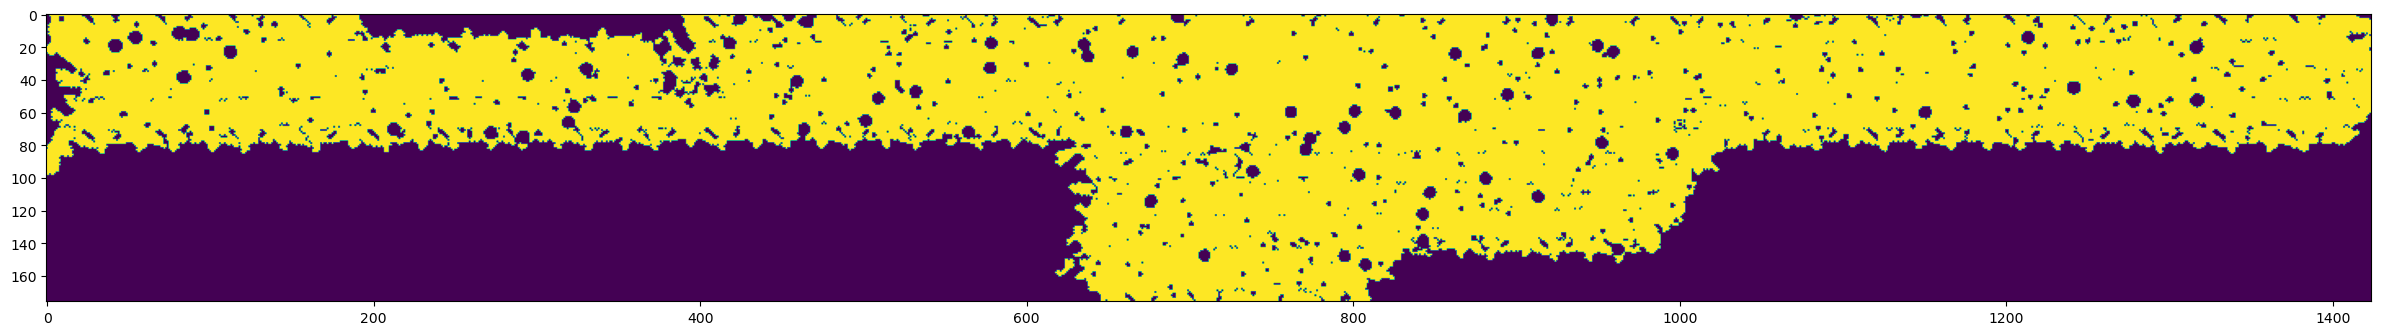

In [ ]:
# mask
Visualization.plot_mask(mask=data_obj.mask)

noiseless training convergence map: The convergence maps show the projected matter density (including dark matter and ordinary matter) in the simulated universe, under the Born approximation. On large scales, we can see the matter forms web-like structures (cosmic web) in the universe. The dense regions in these maps, called dark matter halos, are the sites where galaxies form and reside.

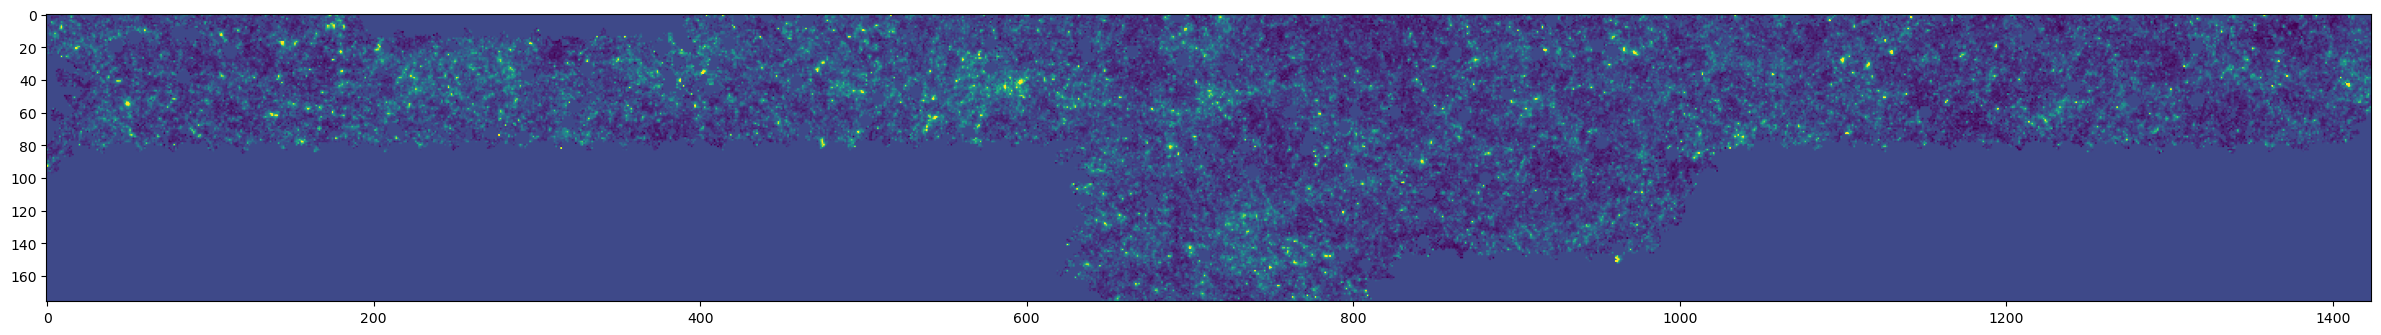

In [ ]:
# noiseless training convergence map
Visualization.plot_noiseless_training_convergence_map(kappa=data_obj.kappa)

noisy training convergence map: We add Gaussian noise to the data. This mimics the observed data. During training the noise can be added on the fly with different realizations.

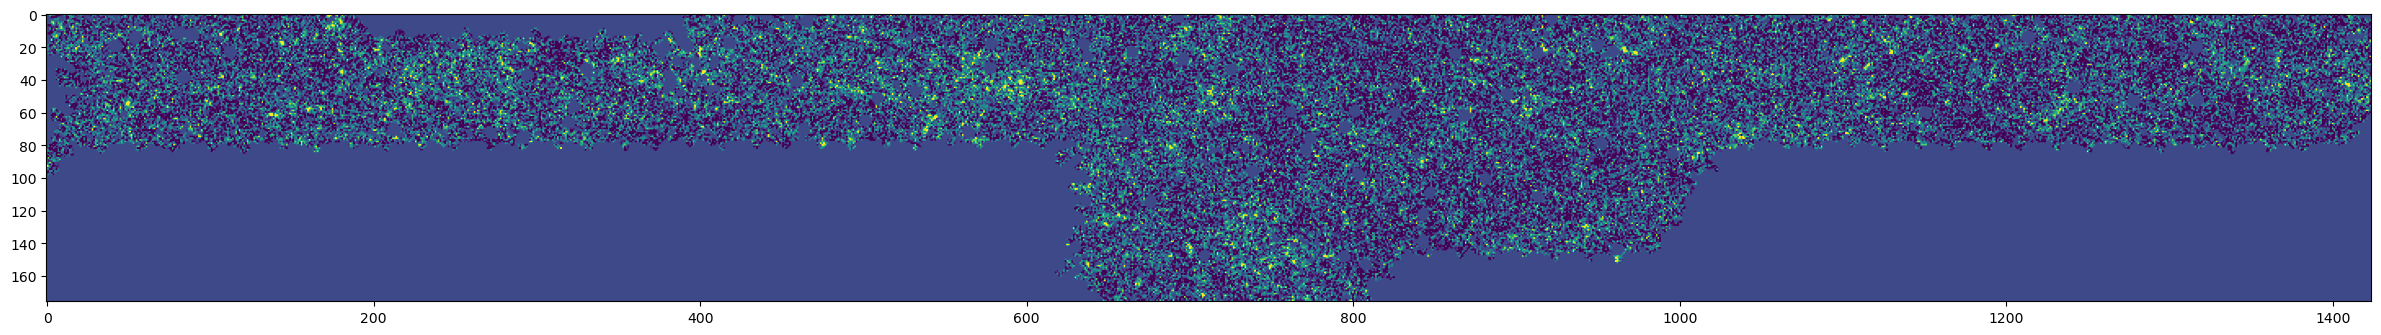

In [ ]:
# noisy training convergence map
Visualization.plot_noisy_training_convergence_map(kappa=data_obj.kappa, pixelsize_arcmin=data_obj.pixelsize_arcmin, ng=data_obj.ng)

### Distribution of physical parameters

Distribution of cosmological parameters $\Omega_m$ and $S_8$. The density increases towards fiducial cosmology. Note that this distribution introduces a prior in the analysis. The test data cosmology follows the same distribution as the training data.

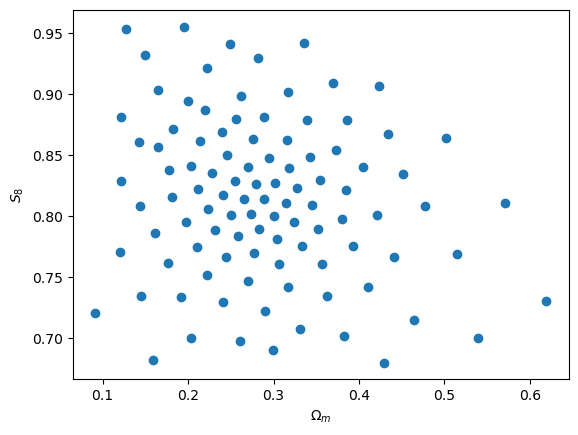

In [ ]:
Visualization.plot_cosmological_parameters_OmegaM_S8(label=data_obj.label)

Distribution of baryonic physics parameters. These are nuisance parameters and should be marginalized in the analysis. They follow a uniform distribution within the prior range $T_{\mathrm{AGN}} \in [7.2, 8.5]$, $f_0 \in [0, 0.0265]$

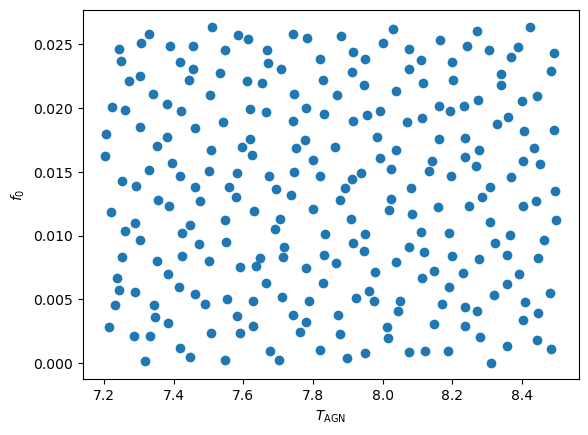

In [ ]:
Visualization.plot_baryonic_physics_parameters(label=data_obj.label)

Distribution of photometric redshift uncertainty parameters. This is a nuisance parameter and should be marginalized in the analysis. It follows a Gaussian distribution with mean 0 and std 0.022

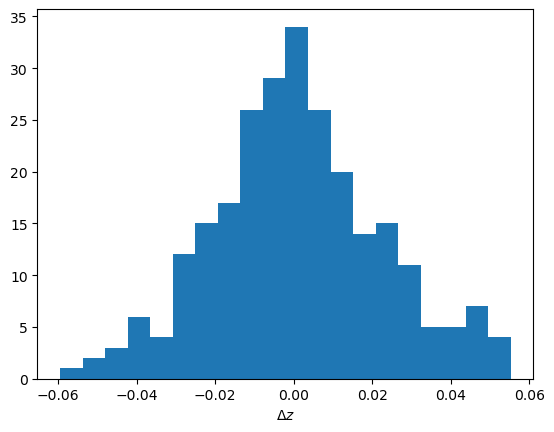

In [ ]:
Visualization.plot_photometric_redshift_uncertainty_parameters(label=data_obj.label)

# 4 - Training (build power spectrum and covariance emulator)

In cosmology, the power spectrum describes how matter is distributed across different size scales in the universe and is a key tool for studying the growth of cosmic structure. Starting from the matter density $\delta(x)$, we transform it into Fourier space to get $\tilde{\delta}(x)$, which represents fluctuations as waves of different wavelengths. The matter power spectrum P(k) is then defined by:

\begin{equation}
\langle \tilde{\delta}(\mathbf{k}) \tilde{\delta}^*(\mathbf{k}') \rangle = (2\pi)^3 \delta_D(\mathbf{k}-\mathbf{k}') P(k),
\end{equation}

where k is the wavenumber corresponding to a scale $\lambda \sim 1/k$, and $ \delta_D$ is the Dirac delta function. Intuitively, P(k) tells us how "clumpy" the universe is on different scales. In cosmology, the shape and amplitude of P(k) encodes the physics and composition of the universe, making it one of the most important statistical tools in the field.

In this notebook we use power spectrum as the summary statistic to constrain the cosmological parameters.

In [ ]:
l_edge = np.logspace(2, 4, 11)

In [ ]:
def power_spectrum(x, pixsize, kedge):
    """
    Compute the azimuthally averaged 2D power spectrum of a real-valued 2D field.

    Parameters:
    -----------
    x : 2D numpy array
        Input real-space map (e.g., an image or simulated field).
        Must be a 2D array with shape (N_y, N_x).
    
    pixsize : float
        Physical size of each pixel in the map (e.g., arcmin, Mpc, etc.).
        Units should be consistent with the units used for `kedge`.
    
    kedge : 1D array-like
        Bin edges in wavenumber space (k), used to bin the power spectrum.
        Should be monotonically increasing and cover the k-range of interest.

    Returns:
    --------
    power_k : 1D numpy array
        The average wavenumber in each k bin (excluding the DC bin).
    
    power : 1D numpy array
        The binned, azimuthally averaged power spectrum corresponding to `power_k`.
        Normalized per unit area.
    """

    # Ensure the input array is 2D
    assert x.ndim == 2

    # Compute the 2D FFT of the input map and take its squared magnitude (power spectrum)
    xk = np.fft.rfft2(x)  # Real-to-complex FFT (along last axis)
    xk2 = (xk * xk.conj()).real  # Power spectrum: |FFT|^2

    # Get the shape of the input map
    Nmesh = x.shape

    # Compute the wavenumber grid (k-space)
    k = np.zeros((Nmesh[0], Nmesh[1]//2+1))
    # Square of the frequency in the first axis
    k += np.fft.fftfreq(Nmesh[0], d=pixsize).reshape(-1, 1) ** 2
    # Square of the frequency in the second axis (real FFT)
    k += np.fft.rfftfreq(Nmesh[1], d=pixsize).reshape(1, -1) ** 2
    # Convert from (1/length)^2 to angular frequency in radian units
    k = k ** 0.5 * 2 * np.pi

    # Bin each k value according to the bin edges provided in kedge
    index = np.searchsorted(kedge, k)

    # Bin the power values, number of modes, and wavenumbers
    power = np.bincount(index.flatten(), weights=xk2.flatten())
    Nmode = np.bincount(index.flatten())
    power_k = np.bincount(index.flatten(), weights=k.flatten())

    # Adjust for symmetry in the real FFT: include the mirrored part (excluding Nyquist frequency)
    if Nmesh[1] % 2 == 0:  # Even number of columns
        power += np.bincount(index[...,1:-1].flatten(), weights=xk2[...,1:-1].flatten())
        Nmode += np.bincount(index[...,1:-1].flatten())
        power_k += np.bincount(index[...,1:-1].flatten(), weights=k[...,1:-1].flatten())
    else:  # Odd number of columns
        power += np.bincount(index[...,1:].flatten(), weights=xk2[...,1:].flatten())
        Nmode += np.bincount(index[...,1:].flatten())
        power_k += np.bincount(index[...,1:].flatten(), weights=k[...,1:].flatten())

    # Exclude the first bin (typically corresponds to DC mode)
    power = power[1:len(kedge)]
    Nmode = Nmode[1:len(kedge)]
    power_k = power_k[1:len(kedge)]

    # Average the power and wavenumber in each bin, only where Nmode > 0
    select = Nmode > 0
    power[select] = power[select] / Nmode[select]
    power_k[select] = power_k[select] / Nmode[select]

    # Normalize the power spectrum by the map area
    power *= pixsize ** 2 / Nmesh[0] / Nmesh[1]

    # Return the binned k values and corresponding power spectrum
    return power_k, power

### calculate the power spectrum for all maps

In [ ]:
# This takes a few minutes
Cl =  np.zeros((101,256,4))

for i in range(101):
    for j in range(256):
        l, Cl[i,j] = power_spectrum(Utility.add_noise(
            data=data_obj.kappa[i,j].astype(np.float64), 
            mask=data_obj.mask, 
            ng=data_obj.ng, 
            pixel_size=data_obj.pixelsize_arcmin
        ), data_obj.pixelsize_radian, l_edge)

Utility.save_np(data_dir=DATA_DIR, file_name="allPS.npy",data=Cl)

### mean power spectrum and covariance for 101 cosmological model

In [ ]:
# Here we use logCl instead of Cl as the summary statistics
logCl = np.log10(Utility.load_np(data_dir=DATA_DIR, file_name="allPS.npy"))

# mean power spectrum
mean_logCl = np.mean(logCl, 1)
Utility.save_np(data_dir=DATA_DIR, file_name="meanlogPS.npy",data=mean_logCl)

# covariance matrix
delta = (logCl - mean_logCl[:,None])
cov_logCl = [(delta[i].T @ delta[i] / (len(delta[i])-delta.shape[-1]-2))[None] for i in range(101)]
cov_logCl = np.concatenate(cov_logCl, 0)
Utility.save_np(data_dir=DATA_DIR, file_name="covlogPS.npy", data=cov_logCl)

### Power spectrum emulator (linear interpolation between 101 cosmological models)

In [ ]:
from scipy.interpolate import LinearNDInterpolator

# only uses cosmological parameters (the first two parameters) here. The other parameters are nuisance parameters and contain useful information. Here we marginalize the nuisance parameters by ignoring them.
cosmology = data_obj.label[:,0,:2]
mean_logCl = Utility.load_np(data_dir=DATA_DIR, file_name="meanlogPS.npy")
cov_logCl = Utility.load_np(data_dir=DATA_DIR, file_name="covlogPS.npy")

meanlogCl_interp = LinearNDInterpolator(cosmology, mean_logCl, fill_value=np.nan)
covlogCl_interp = LinearNDInterpolator(cosmology, cov_logCl, fill_value=np.nan)

### Define prior, likelihood, posterior

In [10]:
logprior_interp = LinearNDInterpolator(cosmology, np.zeros((101,1)), fill_value=-np.inf)

# Note that the training data are not uniformly sampled, which introduces a prior distribution. Here we ignores that prior for simplicity.
# Also note that this prior would introduce bias for cosmologies at the boundary at the prior
def log_prior(x):
    logprior = logprior_interp(x).flatten()
    return logprior

# Gaussian likelihood with interpolated mean and covariance matrix
def loglike(x, logPS):
    mean = meanlogCl_interp(x)
    cov = covlogCl_interp(x)
    delta = logPS - mean
    
    inv_cov = np.linalg.inv(cov)
    cov_det = np.linalg.slogdet(cov)[1]
    
    return -0.5 * cov_det - 0.5 * np.einsum("ni,nij,nj->n", delta, inv_cov, delta)

def logp_posterior(x, logPS):
    logp = log_prior(x)
    select = np.isfinite(logp)
    if np.sum(select) > 0:
        logp[select] = logp[select] + loglike(x[select], logPS[select])
    return logp

# 5 - Phase one inference

### estimate power spectrum for all test data

In [ ]:
test_Cl = np.zeros((data_obj.Ntest, 10))

for i in range(data_obj.Ntest):
    l, test_Cl[i] = power_spectrum(data_obj.kappa_test[i].astype(np.float64), data_obj.pixelsize_radian, l_edge)

test_logCl = np.log10(test_Cl)

### Sample the posterior!

In [ ]:
# MCMC sampling to explore the posterior distribution

Nstep = 100000   # Number of MCMC steps (iterations)
sigma = 0.02     # Proposal standard deviation; should be tuned per method or parameter scale

# Randomly select initial points from the `cosmology` array for each test case
# Assumes `cosmology` has shape (101, ndim) and `Ntest` is the number of independent chains/samples
current = cosmology[np.random.choice(101, size=data_obj.Ntest)]

# Compute log-posterior at the initial points
curr_logprob = logp_posterior(current, test_logCl)

# List to store sampled states (for all chains)
states = []

# Track total acceptance probabilities to compute acceptance rates
total_acc = np.zeros(len(current))

t = time.time()  # Track time for performance reporting

# MCMC loop
for i in range(Nstep):

    # Generate proposals by adding Gaussian noise to current state
    proposal = current + np.random.randn(*current.shape) * sigma

    # Compute log-posterior at the proposed points
    proposal_logprob = logp_posterior(proposal, test_logCl)

    # Compute log acceptance ratio (Metropolis-Hastings)
    acc_logprob = proposal_logprob - curr_logprob
    acc_logprob[acc_logprob > 0] = 0  # Cap at 0 to avoid exp overflow (acceptance prob ≤ 1)

    # Convert to acceptance probabilities
    acc_prob = np.exp(acc_logprob)

    # Decide whether to accept each proposal
    acc = np.random.uniform(size=len(current)) < acc_prob

    # Track acceptance probabilities (not binary outcomes)
    total_acc += acc_prob

    # Update states and log-probs where proposals are accepted
    current[acc] = proposal[acc]
    curr_logprob[acc] = proposal_logprob[acc]

    # Save a copy of the current state
    states.append(np.copy(current)[None])

    # Periodically print progress and acceptance rates
    if i % 1000 == 999:
        print(
            'step:', len(states),
            'Time:', time.time() - t,
            'Min acceptance rate:', np.min(total_acc / (i + 1)),
            'Mean acceptance rate:', np.mean(total_acc / (i + 1))
        )
        t = time.time()  # Reset timer for next print interval

step: 1000 Time: 23.13399052619934 Min acceptance rate: 0.21658684544205623 Mean acceptance rate: 0.6842716479450729
step: 2000 Time: 23.75026845932007 Min acceptance rate: 0.24426624895462404 Mean acceptance rate: 0.6841816556701494
step: 3000 Time: 23.031208038330078 Min acceptance rate: 0.2449519288309527 Mean acceptance rate: 0.684217572548944
step: 4000 Time: 24.83819341659546 Min acceptance rate: 0.24644112213556182 Mean acceptance rate: 0.6841454557886957
step: 5000 Time: 25.604341506958008 Min acceptance rate: 0.2368561211679887 Mean acceptance rate: 0.6840956166073348
step: 6000 Time: 28.25268292427063 Min acceptance rate: 0.23577716160731257 Mean acceptance rate: 0.6840967301613113
step: 7000 Time: 31.146915674209595 Min acceptance rate: 0.23891960086266967 Mean acceptance rate: 0.6840425414747715
step: 8000 Time: 28.82492232322693 Min acceptance rate: 0.2409398354690337 Mean acceptance rate: 0.6840784950343464
step: 9000 Time: 20.313328742980957 Min acceptance rate: 0.242003

In [16]:
# remove burn in
states = np.concatenate(states[20000:], 0)

# mean and std of samples
mean = np.mean(states, 0)
errorbar = np.std(states, 0)

# 6 - Evaluate the scores

In [ ]:
score = Score.score_phase1(
    true_cosmo=data_obj.label_test,
    infer_cosmo=mean,
    errorbar=errorbar
)

print('averaged score:', np.mean(score))
print('averaged error bar:', np.mean(errorbar, 0))

averaged score: 5.131011209811511
averaged error bar: [0.06300786 0.03618408]


# 7 - (Optional) Prepare submission for Codabench

In [ ]:
data = {"means": mean, "errorbars": errorbar}
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
zip_file_name = 'Submission_' + the_date + '.zip'
zip_file = Utility.save_json_zip(
    submission_dir="submissions",
    json_file_name="result.zip",
    submission_file_name=zip_file_name,
    data=data
)
print(f"Submission ZIP saved at: {zip_file}")